# Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.manifold import TSNE
from torchvision.utils import make_grid, save_image
from PIL import Image

# Load MNIST dataset
from data import train_loader, test_loader

# Build Variational AutoEncoder

Q. Why should we model log variance instead of variance directly?

A. https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig

In [2]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, img_size=28):
        super().__init__()

        # Build encoder
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(32, 16)  # mean of latent space
        self.fc_var = nn.Linear(32, 16) # **log variance** of latent space

        # Build decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, img_size * img_size),
            nn.Tanh(),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Train

Let's use Adam optimizer and beautiful loss function. 

In [3]:
# Deriving the KLD Loss: https://arxiv.org/pdf/1907.08956v1.pdf
reconstruction_function = nn.MSELoss(size_average=False)
def loss_func(x, x_hat, mu, log_var):
    reconstruction_loss = reconstruction_function(x_hat, x)
    kld_loss = torch.sum(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return reconstruction_loss + kld_loss, reconstruction_loss, kld_loss

/home/baek/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [4]:
# Check whether gpu is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device: {}".format(device))

Using device: cuda


In [5]:
model = VariationalAutoEncoder(img_size=28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        # ===================forward=====================
        output, mu, log_var = model(img)
        loss, reconstruction_loss, kld_loss = loss_func(output, img, mu, log_var)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print("epoch [{}/{}], loss:{:.4f}, recons_loss:{:.4f}, kld_loss:{:.4f}".format(epoch + 1, 10, loss.item(), reconstruction_loss.item(), kld_loss.item()))

epoch [1/10], loss:4921.7915, recons_loss:4593.4268, kld_loss:328.3647
epoch [2/10], loss:3949.2852, recons_loss:3561.3669, kld_loss:387.9181
epoch [3/10], loss:3187.3735, recons_loss:2758.3503, kld_loss:429.0232
epoch [4/10], loss:2985.1794, recons_loss:2576.2646, kld_loss:408.9149
epoch [5/10], loss:3348.4294, recons_loss:2924.6675, kld_loss:423.7619
epoch [6/10], loss:3478.9873, recons_loss:3056.2036, kld_loss:422.7836
epoch [7/10], loss:3416.7012, recons_loss:2989.5391, kld_loss:427.1622
epoch [8/10], loss:2666.1196, recons_loss:2235.2046, kld_loss:430.9149
epoch [9/10], loss:3057.2561, recons_loss:2616.0464, kld_loss:441.2098
epoch [10/10], loss:2529.8262, recons_loss:2122.1577, kld_loss:407.6686


# Eval - Check the loss

In [6]:
_ = model.eval()
model = model.to("cpu")

recons_loss = []
kld_loss = []
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output, mu, log_var = model(img)
        _, recons_l, kld_l = loss_func(output, img, mu, log_var)
        recons_loss.append(recons_l.item())
        kld_loss.append(kld_l.item())

print("test recons_loss:{:.4f}, kld_loss:{:.4f}".format(np.array(recons_loss).mean(), np.array(kld_loss).mean()))

test recons_loss:4937.2947, kld_loss:853.0745


# Eval - Feature Representation

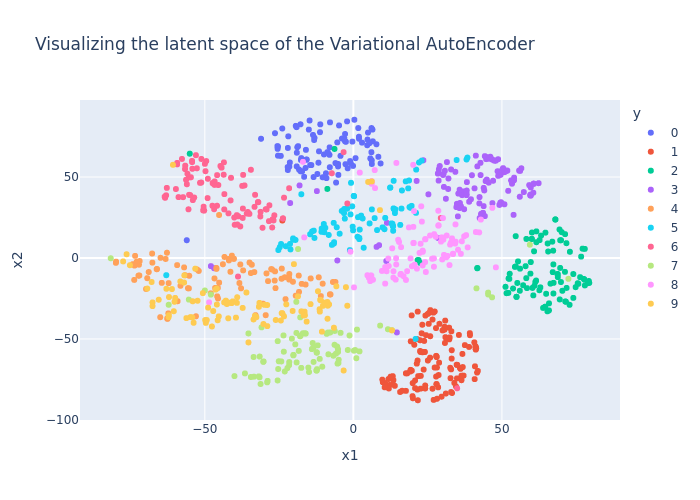

In [7]:
X = []
y = []

with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        X.append(model.encoder(img.view(img.size(0), -1)).numpy())
        y.append(y_real.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

df = pd.DataFrame(data=np.concatenate([X_embedded, y.reshape(-1, 1)], axis=-1), columns=["x1", "x2", "y"])
df["y"] = df["y"].astype(int).astype("category")

fig = px.scatter(df.sample(n=1000).sort_values("y"), x="x1", y="x2", color="y", title="Visualizing the latent space of the Variational AutoEncoder")

fig.write_image("images/vae-fig1.png")
Image.open("images/vae-fig1.png")

# Eval - Reconstruction

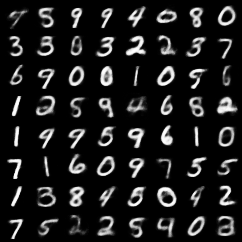

In [8]:
with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        output, _, _ = model(img.view(img.size(0), -1))
        break

img_grid = make_grid(output.reshape(-1, 1, 28, 28), nrow=8, normalize=True)
save_image(img_grid, "images/vae-fig2.png")
Image.open("images/vae-fig2.png")

# Eval - Generation

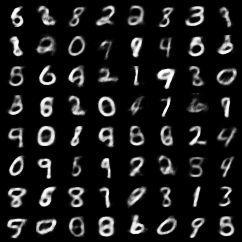

In [9]:
z = torch.randn_like(torch.empty(64, 16))
output = model.decode(z)
img_grid = make_grid(output.reshape(-1, 1, 28, 28), nrow=8, normalize=True)
save_image(img_grid, "images/vae-fig3.png")
Image.open("images/vae-fig3.png")